<a href="https://colab.research.google.com/github/dokin0802/SinGAN/blob/master/fin_singan_re_da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
path = '/content/drive/MyDrive/architecture_aug/ex2/augf2/p'
g = glob.glob(path+'/*')

def rename(files):
  for i,f in enumerate(files):
      os.rename(f, os.path.join(path, 'p_' + '{0:03d}.jpg'.format(i)))

In [ ]:
rename(g)


In [4]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
dir_ = Path('/content/drive/MyDrive/architecture_aug/ex2/augf2')
filepaths = list(dir_.glob(r'**/*.jpg'))
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)

    return df

df = proc_img(filepaths)
df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/architecture_aug/ex2/au...,Deconstructivism
1,/content/drive/MyDrive/architecture_aug/ex2/au...,Baroque
2,/content/drive/MyDrive/architecture_aug/ex2/au...,Gothic
3,/content/drive/MyDrive/architecture_aug/ex2/au...,Baroque
4,/content/drive/MyDrive/architecture_aug/ex2/au...,Gothic


In [6]:
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 1500

Number of different labels: 6

Labels: ['Deconstructivism' 'Baroque' 'Gothic' 'Romanesque' 'International'
 'Postmodern']


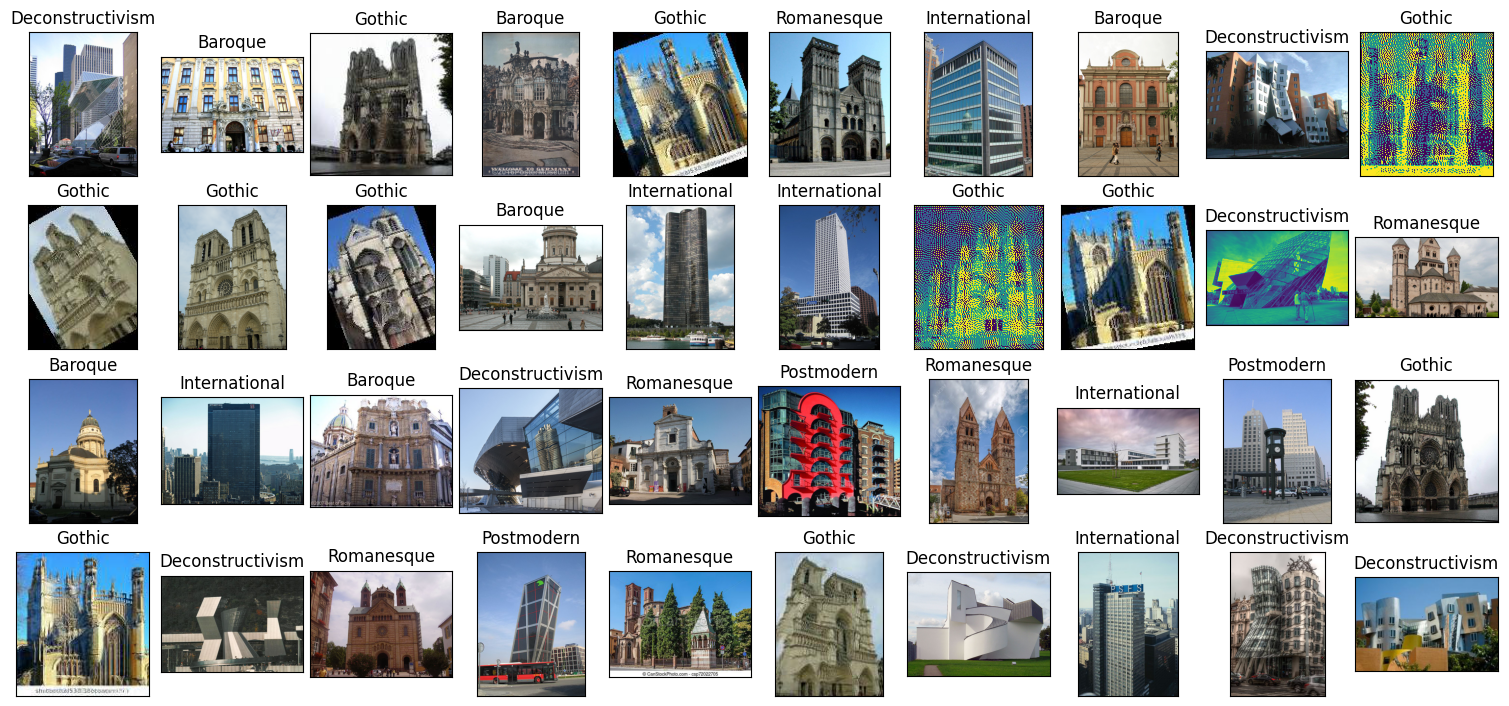

In [7]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

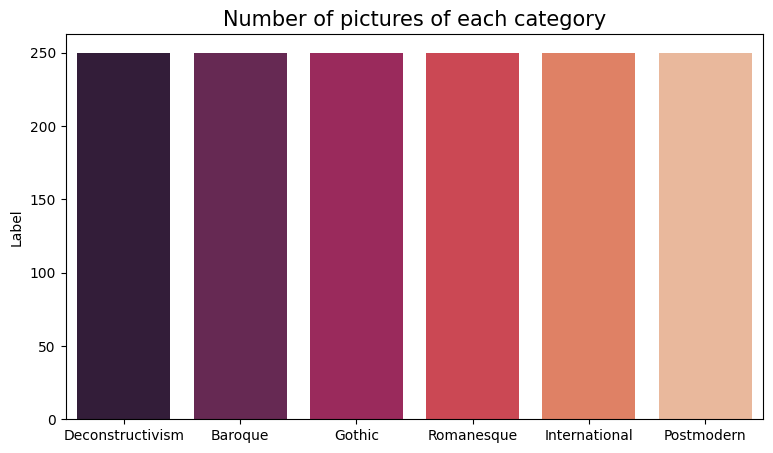

In [8]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [9]:
train_df =df

dir_ = Path('/content/drive/MyDrive/architecture_small/test')
filepaths = list(dir_.glob(r'**/*.jpg'))
test_df = proc_img(filepaths)

In [10]:
import numpy as np
import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.20)

train_gen = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory('/content/drive/MyDrive/architecture_aug/ex2/augf2',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 1200 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [11]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [12]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 1)

38/38 [==============================] - 697s 18s/step - loss: 1.6654 - accuracy: 0.3425 - val_loss: 1.8856 - val_accuracy: 0.2567


In [13]:

test_datagen =  ImageDataGenerator(rescale=1/255)

test_gen  = test_datagen.flow_from_directory('/content/drive/MyDrive/architecture_small/test',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 300 images belonging to 6 classes.


In [12]:
cnn.evaluate(test_gen)

KeyboardInterrupt: ignored

In [14]:
# Predict the label of the test_images
pred = cnn.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')


10/10 [==============================] - 158s 17s/step
Accuracy on the test set: 17.33%


In [15]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.17      0.42      0.24        50
Deconstructivism       0.17      0.26      0.21        50
          Gothic       0.43      0.06      0.11        50
   International       0.25      0.02      0.04        50
      Postmodern       0.13      0.14      0.14        50
      Romanesque       0.18      0.14      0.16        50

        accuracy                           0.17       300
       macro avg       0.22      0.17      0.15       300
    weighted avg       0.22      0.17      0.15       300



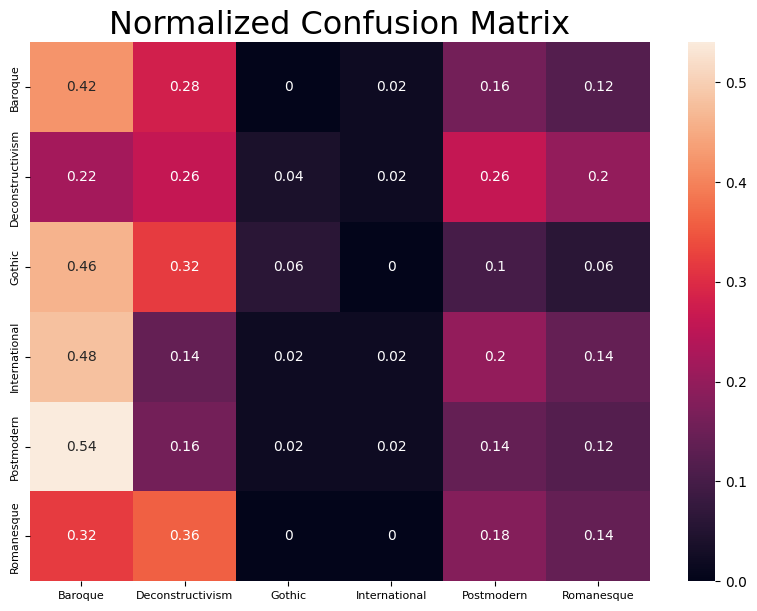

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [17]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [18]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    # 라벨 개수가 8개이기 때문에 Dencs도 8로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Train모델 학습
for name, model in models.items():

    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m

    start = perf_counter()

    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)

    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


29084464/29084464 [==============================] - 3s 0us/step
DenseNet121          trained in 19.59 sec
9406464/9406464 [==============================] - 2s 0us/step
MobileNetV2          trained in 14.99 sec
74836368/74836368 [==============================] - 4s 0us/step
DenseNet201          trained in 24.61 sec
16705208/16705208 [==============================] - 2s 0us/step
EfficientNetB0       trained in 19.23 sec
27018416/27018416 [==============================] - 2s 0us/step
EfficientNetB1       trained in 22.45 sec
87910968/87910968 [==============================] - 5s 0us/step
InceptionV3          trained in 18.08 sec
12683000/12683000 [==============================] - 2s 0us/step
MobileNetV3Large     trained in 16.51 sec
234545216/234545216 [==============================] - 12s 0us/step
Re

In [19]:
# test데이터로 모델 성능 예측
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')

# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

10/10 [==============================] - 5s 312ms/step
**DenseNet121 has a 59.00% accuracy on the test set**
10/10 [==============================] - 4s 313ms/step
**MobileNetV2 has a 55.33% accuracy on the test set**
10/10 [==============================] - 6s 319ms/step
**DenseNet201 has a 64.67% accuracy on the test set**
10/10 [==============================] - 5s 312ms/step
**EfficientNetB0 has a 16.33% accuracy on the test set**
10/10 [==============================] - 5s 316ms/step
**EfficientNetB1 has a 15.00% accuracy on the test set**
10/10 [==============================] - 5s 316ms/step
**InceptionV3 has a 55.33% accuracy on the test set**
10/10 [==============================] - 4s 311ms/step
**MobileNetV3Large has a 30.33% accuracy on the test set**
10/10 [==============================] - 6s 317ms/step
**ResNet152V2 has a 63.00% accuracy on the test set**
10/10 [==============================] - 4s 313ms/step
**ResNet50 has a 31.00% accuracy on the test set**
10/10 [====

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.7467,0.6467,24.61
1,ResNet152V2,0.7467,0.6300,22.44
2,DenseNet121,0.7133,0.5900,19.59
3,ResNet50V2,0.7833,0.5767,15.95
4,Xception,0.7667,0.5767,14.91
5,MobileNetV2,0.7333,0.5533,14.99
6,InceptionV3,0.7133,0.5533,18.08
7,VGG19,0.5800,0.4700,14.15
8,VGG16,0.6300,0.4700,12.20
9,ResNet50,0.5067,0.3100,16.04


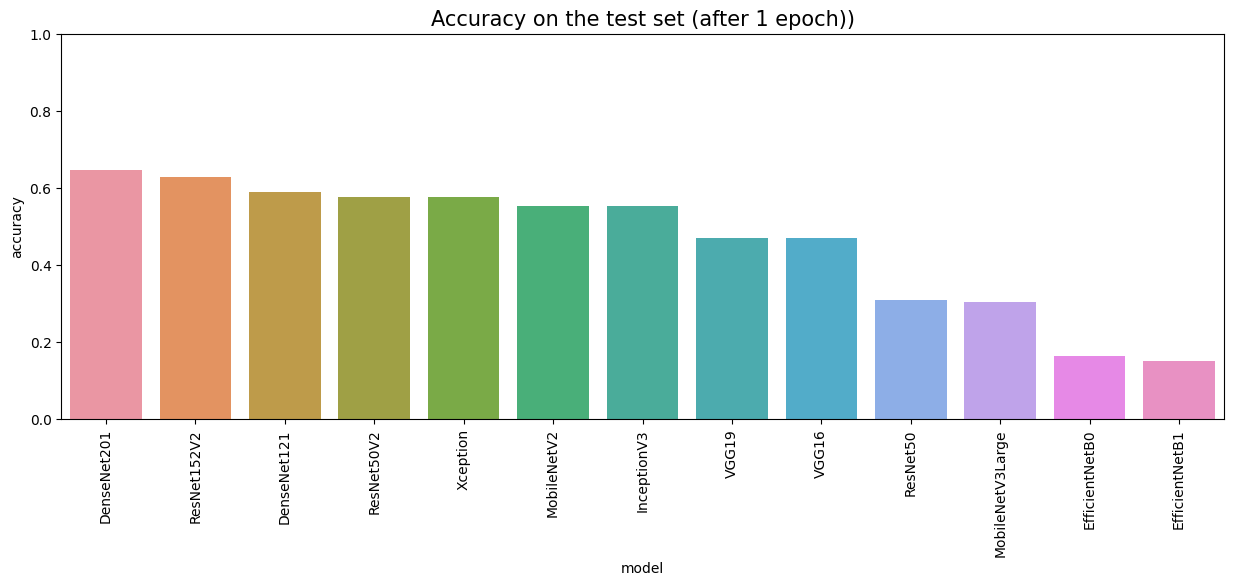

In [20]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [21]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 25s 358ms/step - loss: 0.8723 - accuracy: 0.6558 - val_loss: 0.6119 - val_accuracy: 0.7200
Epoch 2/4
38/38 [==============================] - 10s 274ms/step - loss: 0.4194 - accuracy: 0.8508 - val_loss: 0.4548 - val_accuracy: 0.8300
Epoch 3/4
38/38 [==============================] - 11s 281ms/step - loss: 0.3213 - accuracy: 0.8825 - val_loss: 0.4446 - val_accuracy: 0.8200
Epoch 4/4
38/38 [==============================] - 11s 277ms/step - loss: 0.2832 - accuracy: 0.8892 - val_loss: 0.4817 - val_accuracy: 0.8100


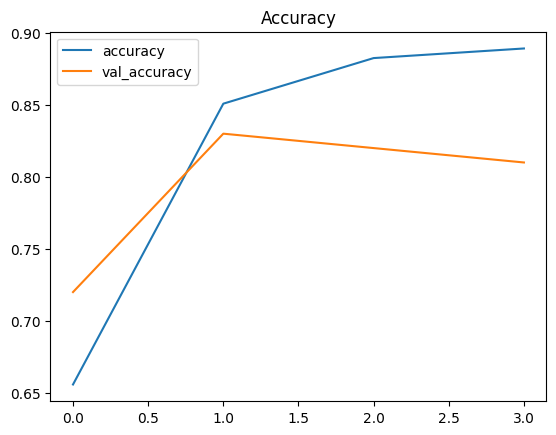

In [22]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

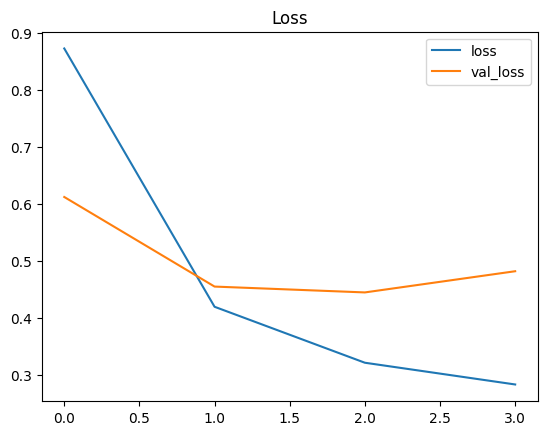

In [23]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [24]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 315ms/step
Accuracy on the test set: 69.67%


In [25]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.66      1.00      0.79        50
Deconstructivism       0.68      0.82      0.75        50
          Gothic       0.78      0.50      0.61        50
   International       0.82      0.62      0.70        50
      Postmodern       0.57      0.60      0.58        50
      Romanesque       0.78      0.64      0.70        50

        accuracy                           0.70       300
       macro avg       0.71      0.70      0.69       300
    weighted avg       0.71      0.70      0.69       300



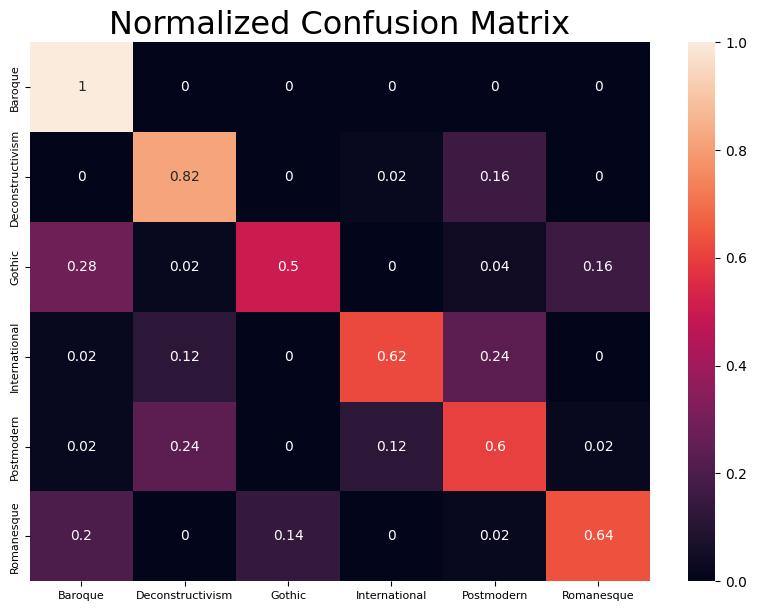

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [27]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet121)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 19s 323ms/step - loss: 1.0030 - accuracy: 0.5892 - val_loss: 0.6601 - val_accuracy: 0.7000
Epoch 2/4
38/38 [==============================] - 10s 273ms/step - loss: 0.5027 - accuracy: 0.8075 - val_loss: 0.6114 - val_accuracy: 0.7467
Epoch 3/4
38/38 [==============================] - 10s 274ms/step - loss: 0.3820 - accuracy: 0.8575 - val_loss: 0.4939 - val_accuracy: 0.7900
Epoch 4/4
38/38 [==============================] - 10s 273ms/step - loss: 0.3442 - accuracy: 0.8658 - val_loss: 0.4852 - val_accuracy: 0.8133


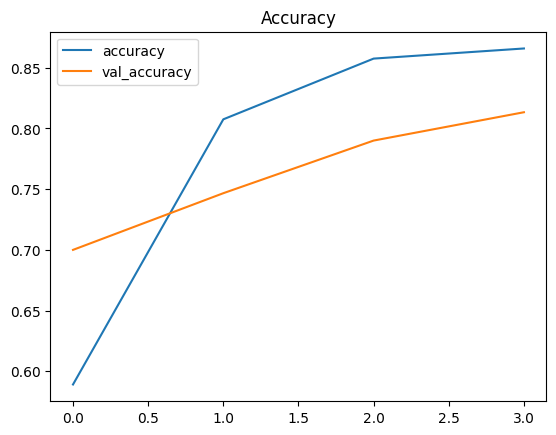

In [28]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

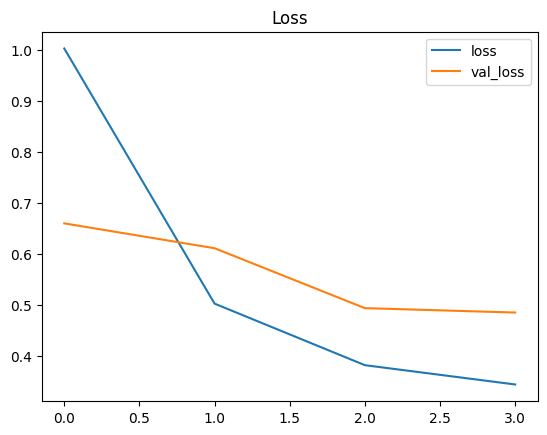

In [29]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [30]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 5s 312ms/step
Accuracy on the test set: 62.00%


In [31]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.59      1.00      0.74        50
Deconstructivism       0.66      0.80      0.72        50
          Gothic       0.75      0.18      0.29        50
   International       0.81      0.52      0.63        50
      Postmodern       0.52      0.56      0.54        50
      Romanesque       0.59      0.66      0.62        50

        accuracy                           0.62       300
       macro avg       0.65      0.62      0.59       300
    weighted avg       0.65      0.62      0.59       300



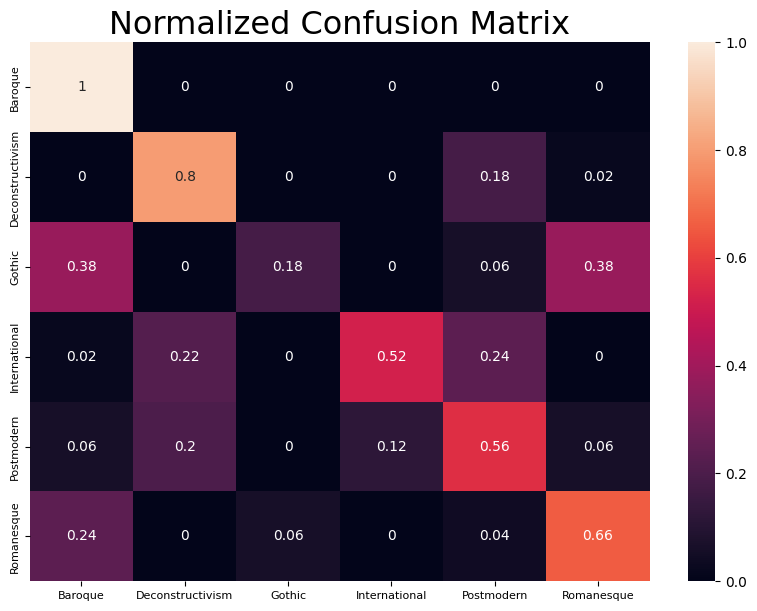

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [33]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.Xception)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 15s 296ms/step - loss: 0.9160 - accuracy: 0.6400 - val_loss: 0.5952 - val_accuracy: 0.7333
Epoch 2/4
38/38 [==============================] - 10s 271ms/step - loss: 0.5201 - accuracy: 0.7800 - val_loss: 0.5789 - val_accuracy: 0.7367
Epoch 3/4
38/38 [==============================] - 10s 274ms/step - loss: 0.4492 - accuracy: 0.8258 - val_loss: 0.5694 - val_accuracy: 0.7467
Epoch 4/4
38/38 [==============================] - 10s 271ms/step - loss: 0.3330 - accuracy: 0.8683 - val_loss: 0.5584 - val_accuracy: 0.7700


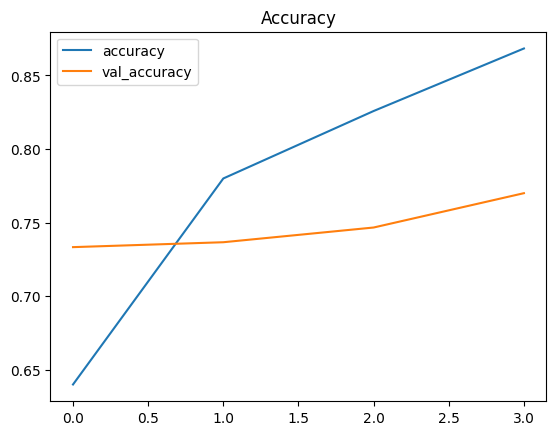

In [34]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

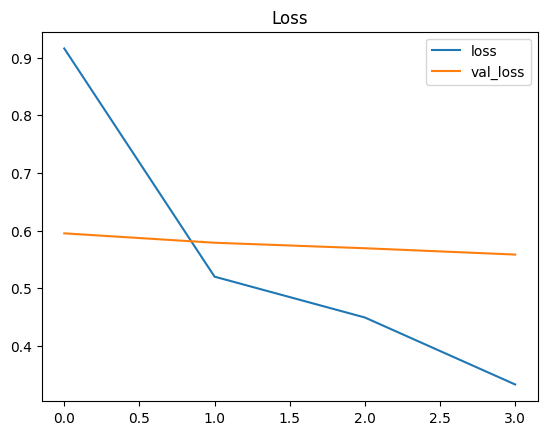

In [35]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [36]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 4s 316ms/step
Accuracy on the test set: 60.67%


In [37]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.91      0.78      0.84        50
Deconstructivism       0.68      0.76      0.72        50
          Gothic       0.67      0.04      0.08        50
   International       0.80      0.40      0.53        50
      Postmodern       0.53      0.70      0.60        50
      Romanesque       0.45      0.96      0.61        50

        accuracy                           0.61       300
       macro avg       0.67      0.61      0.56       300
    weighted avg       0.67      0.61      0.56       300



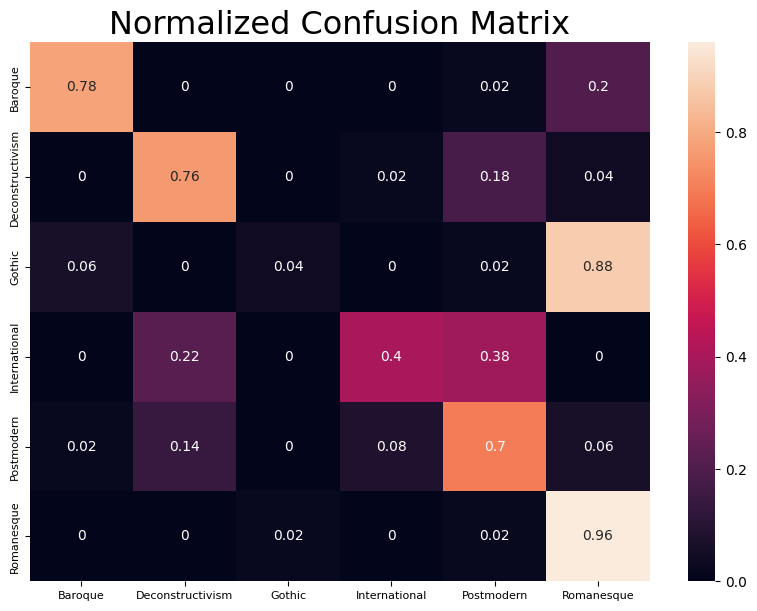

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [39]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 24s 347ms/step - loss: 0.8844 - accuracy: 0.6533 - val_loss: 0.5993 - val_accuracy: 0.7733
Epoch 2/4
38/38 [==============================] - 10s 274ms/step - loss: 0.3998 - accuracy: 0.8358 - val_loss: 0.5415 - val_accuracy: 0.7600
Epoch 3/4
38/38 [==============================] - 10s 273ms/step - loss: 0.2202 - accuracy: 0.9175 - val_loss: 0.5133 - val_accuracy: 0.8067
Epoch 4/4
38/38 [==============================] - 10s 273ms/step - loss: 0.1233 - accuracy: 0.9658 - val_loss: 0.5676 - val_accuracy: 0.8033


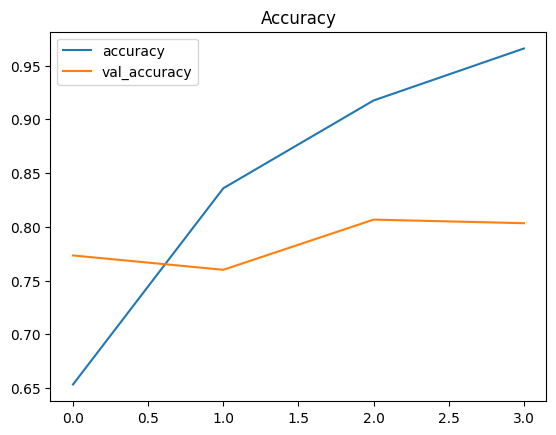

In [40]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

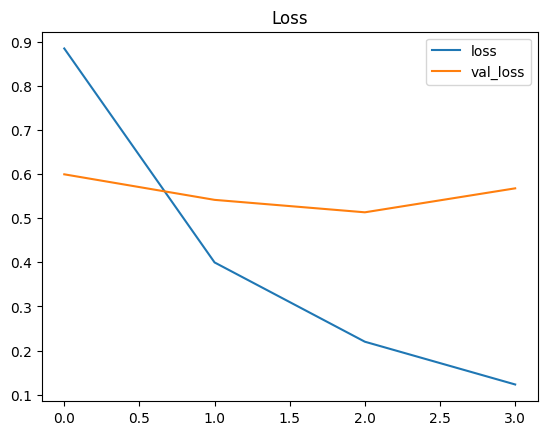

In [41]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [42]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 6s 317ms/step
Accuracy on the test set: 69.33%


In [43]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.90      0.94      0.92        50
Deconstructivism       0.65      0.78      0.71        50
          Gothic       0.85      0.34      0.49        50
   International       0.88      0.56      0.68        50
      Postmodern       0.57      0.66      0.61        50
      Romanesque       0.56      0.88      0.69        50

        accuracy                           0.69       300
       macro avg       0.74      0.69      0.68       300
    weighted avg       0.74      0.69      0.68       300



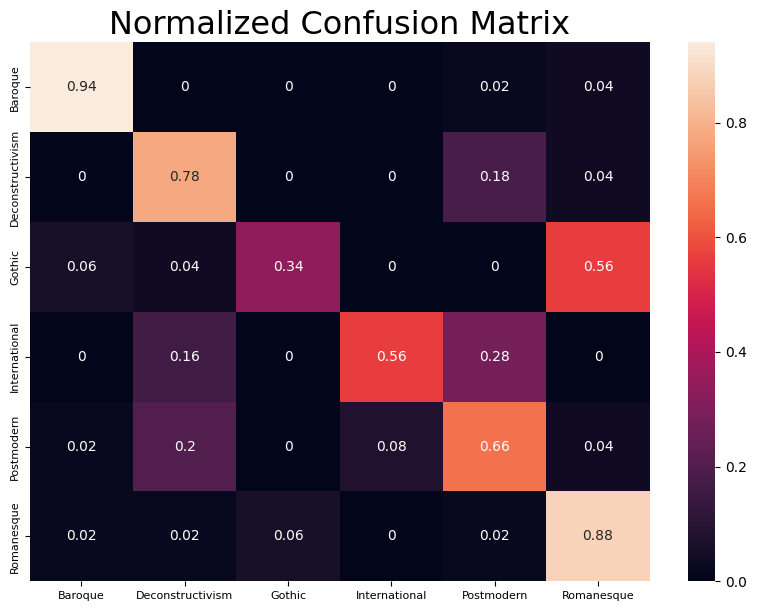

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [45]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.InceptionV3)
history = model.fit(train_images,validation_data=val_images,epochs=4)

Found 1200 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.
Epoch 1/4
38/38 [==============================] - 16s 309ms/step - loss: 1.0242 - accuracy: 0.5642 - val_loss: 0.6598 - val_accuracy: 0.7300
Epoch 2/4
38/38 [==============================] - 10s 273ms/step - loss: 0.5286 - accuracy: 0.7958 - val_loss: 0.5913 - val_accuracy: 0.7600
Epoch 3/4
38/38 [==============================] - 10s 275ms/step - loss: 0.3907 - accuracy: 0.8500 - val_loss: 0.6923 - val_accuracy: 0.7467
Epoch 4/4
38/38 [==============================] - 10s 276ms/step - loss: 0.3224 - accuracy: 0.8842 - val_loss: 0.5594 - val_accuracy: 0.7767


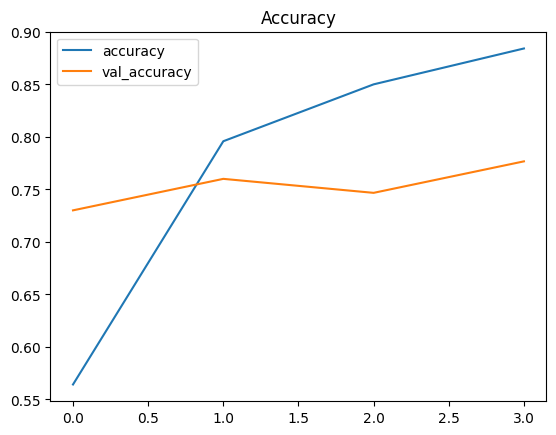

In [46]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

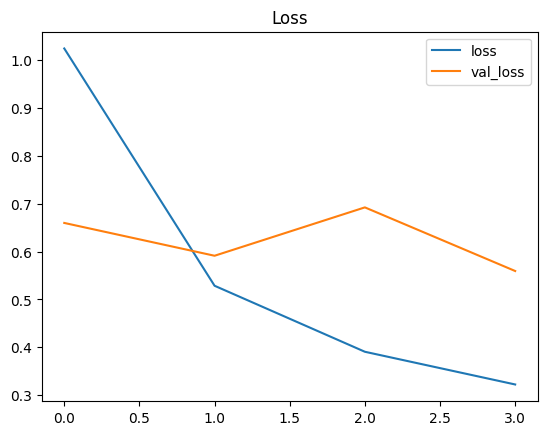

In [47]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [48]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

10/10 [==============================] - 5s 316ms/step
Accuracy on the test set: 61.33%


In [49]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                  precision    recall  f1-score   support

         Baroque       0.88      0.88      0.88        50
Deconstructivism       0.58      0.84      0.69        50
          Gothic       0.80      0.08      0.15        50
   International       0.71      0.58      0.64        50
      Postmodern       0.56      0.40      0.47        50
      Romanesque       0.47      0.90      0.62        50

        accuracy                           0.61       300
       macro avg       0.67      0.61      0.57       300
    weighted avg       0.67      0.61      0.57       300



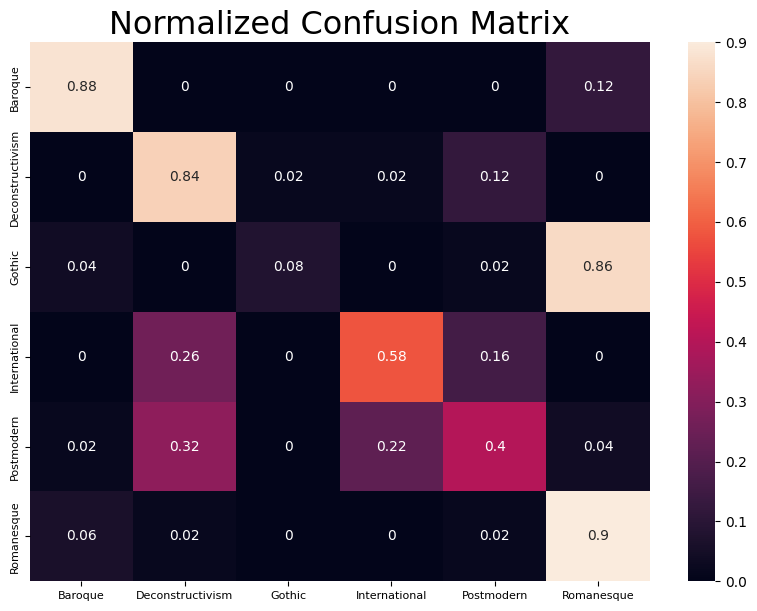

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')



plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=True)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()